The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0
!pip install "syne-tune[gpsearchers]==0.3.2"


# Asynchronous Successive Halving

:label:`sec_sh_async`

As we have seen in :numref:`sec_rs_async`, we can accelerate HPO by
distributing the evaluation of hyperparameter configurations across either
multiple instances or multiples CPUs / GPUs on a single instance. However,
compared to random search, it is not straightforward to run
successive halving (SH) asynchronously in a distributed setting. Before we can
decide which configuration to run next, we first have to collect all
observations at the current rung level. This requires to
synchronize workers at each rung level. For example, for the lowest rung level
$r_{\mathrm{min}}$, we first have to evaluate all $N = \eta^K$ configurations, before we
can promote the $\frac{1}{\eta}$ of them to the next rung level.

In any distributed system, synchronization typically implies idle time for workers.
First, we often observe high variations in training time across hyperparameter
configurations. For example, assuming the number of filters per layer is a
hyperparameter, then networks with less filters finish training faster than
networks with more filters, which implies idle worker time due to stragglers.
Moreover, the number of slots in a rung level is not always a multiple of the number
of workers, in which case some workers may even sit idle for a full batch.

Figure :numref:`synchronous_sh` shows the scheduling of synchronous SH with $\eta=2$
for four different trials with two workers. We start with evaluating Trial-0 and
Trial-1 for one epoch and immediately continue with the next two trials once they
are finished. We first have to wait until Trial-2 finishes, which takes
substantially more time than the other trials, before we can promote the best two
trials, i.e., Trial-0 and Trial-3 to the next rung level. This causes idle time for
Worker-1. Then, we continue with Rung 1. Also, here Trial-3 takes longer than Trial-0,
which leads to an additional ideling time of Worker-0. Once, we reach Rung-2, only
the best trial, Trial-0, remains which occupies only one worker. To avoid that
Worker-1 idles during that time, most implementaitons of SH continue already with
the next round, and start evaluating new trials (e.g Trial-4) on the first rung.

![Synchronous successive halving with two workers.](http://d2l.ai/_images/sync_sh.svg)
:label:`synchronous_sh`

Asynchronous successive halving (ASHA) :cite:`li-arxiv18` adapts SH to the asynchronous
parallel scenario. The main idea of ASHA is to promote configurations to the next rung
level as soon as we collected at least $\eta$ observations on the current rung level.
This decision rule may lead to suboptimal promotions: configurations can be promoted to the
next rung level, which in hindsight do not compare favourably against most others
at the same rung level. On the other hand, we get rid of all synchronization points
this way. In practice, such suboptimal initial promotions have only a modest impact on
performance, not only because the ranking of hyperparameter configurations is often
fairly consistent across rung levels, but also because rungs grow over time and
reflect the distribution of metric values at this level better and better. If a
worker is free, but no configuration can be promoted, we start a new configuration
with $r = r_{\mathrm{min}}$, i.e the first rung level.

:numref:`asha` shows the scheduling of the same configurations for ASHA. Once Trial-1
finishes, we collect the results of two trials (i.e Trial-0 and Trial-1) and
immediately promote the better of them (Trial-0) to the next rung level. After Trial-0
finishes on rung 1, there are too few trials there in order to support a further
promotion. Hence, we continue with rung 0 and evaluate Trial-3. Once Trial-3 finishes,
Trial-2 is still pending. At this point we have 3 trials evaluated on rung 0 and one
trial evaluated already on rung 1. Since Trial-3 performs worse than Trial-0 at rung 0,
and $\eta=2$, we cannot promote any new trial yet, and Worker-1 starts Trial-4 from
scratch instead. However, once Trial-2 finishes and
scores worse than Trial-3, the latter is promoted towards rung 1. Afterwards, we
collected 2 evaluations on rung 1, which means we can now promote Trial-0 towards
rung 2. At the same time, Worker-1 continues with evaluating new trials (i.e.,
Trial-5) on rung 0.


![Asynchronous successive halving (ASHA) with two workers.](http://d2l.ai/_images/asha.svg)
:label:`asha`


In [1]:
import logging
from d2l import torch as d2l

logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import ASHA

INFO:root:SageMakerBackend is not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[extra]'


AWS dependencies are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[aws]'
or (for everything)
   pip install 'syne-tune[extra]'
AWS dependencies are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[aws]'
or (for everything)
   pip install 'syne-tune[extra]'


INFO:root:Ray Tune schedulers and searchers are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[raytune]'
or (for everything)
   pip install 'syne-tune[extra]'


## Objective Function

We will use *Syne Tune* with the same objective function as in
:numref:`sec_rs_async`.


In [2]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter
    from d2l import torch as d2l

    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    report = Reporter()
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # Initialize the state of Trainer
            trainer.fit(model=model, data=data)
        else:
            trainer.fit_epoch()
        validation_error = trainer.validation_error().cpu().detach().numpy()
        report(epoch=epoch, validation_error=float(validation_error))

We will also use the same configuration space as before:


In [3]:
min_number_of_epochs = 2
max_number_of_epochs = 10
eta = 2

config_space = {
    "learning_rate": loguniform(1e-2, 1),
    "batch_size": randint(32, 256),
    "max_epochs": max_number_of_epochs,
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

## Asynchronous Scheduler

First, we define the number of workers that evaluate trials concurrently. We
also need to specify how long we want to run random search, by defining an
upper limit on the total wall-clock time.


In [4]:
n_workers = 2  # Needs to be <= the number of available GPUs
max_wallclock_time = 12 * 60  # 12 minutes

The code for running ASHA is a simple variation of what we did for asynchronous
random search.


In [5]:
mode = "min"
metric = "validation_error"
resource_attr = "epoch"

scheduler = ASHA(
    config_space,
    metric=metric,
    mode=mode,
    points_to_evaluate=[initial_config],
    max_resource_attr="max_epochs",
    resource_attr=resource_attr,
    grace_period=min_number_of_epochs,
    reduction_factor=eta,
)

INFO:syne_tune.optimizer.schedulers.fifo:max_resource_level = 10, as inferred from config_space


INFO:syne_tune.optimizer.schedulers.fifo:Master random_seed = 4141536384


Here, `metric` and `resource_attr` specify the key names used with the `report`
callback, and `max_resource_attr` denotes which input to the objective function
corresponds to $r_{\mathrm{max}}$. Moreover, `grace_period` provides $r_{\mathrm{min}}$, and
`reduction_factor` is $\eta$. We can run Syne Tune as before (this will
take about 12 minutes):


In [6]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)
tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
    print_update_interval=int(max_wallclock_time * 0.6),
)
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065


INFO:root:Detected 4 GPUs


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.1 --batch_size 128 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/0/checkpoints


INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 0.1, 'batch_size': 128, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.016393465295512565 --batch_size 109 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/1/checkpoints


INFO:syne_tune.tuner:(trial 1) - scheduled config {'learning_rate': 0.016393465295512565, 'batch_size': 109, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.8536433102570197 --batch_size 249 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/2/checkpoints


INFO:syne_tune.tuner:(trial 2) - scheduled config {'learning_rate': 0.8536433102570197, 'batch_size': 249, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.02238278285575226 --batch_size 241 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/3/checkpoints


INFO:syne_tune.tuner:(trial 3) - scheduled config {'learning_rate': 0.02238278285575226, 'batch_size': 241, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 2 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.02265916956093905 --batch_size 104 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/4/checkpoints


INFO:syne_tune.tuner:(trial 4) - scheduled config {'learning_rate': 0.02265916956093905, 'batch_size': 104, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.08152606473767814 --batch_size 144 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/5/checkpoints


INFO:syne_tune.tuner:(trial 5) - scheduled config {'learning_rate': 0.08152606473767814, 'batch_size': 144, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.03286717277851087 --batch_size 230 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/6/checkpoints


INFO:syne_tune.tuner:(trial 6) - scheduled config {'learning_rate': 0.03286717277851087, 'batch_size': 230, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.2767625103368729 --batch_size 210 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/7/checkpoints


INFO:syne_tune.tuner:(trial 7) - scheduled config {'learning_rate': 0.2767625103368729, 'batch_size': 210, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.20515181717902709 --batch_size 136 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/8/checkpoints


INFO:syne_tune.tuner:(trial 8) - scheduled config {'learning_rate': 0.20515181717902709, 'batch_size': 136, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.01205522192914604 --batch_size 61 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/9/checkpoints


INFO:syne_tune.tuner:(trial 9) - scheduled config {'learning_rate': 0.01205522192914604, 'batch_size': 61, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.06812982725901803 --batch_size 225 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/10/checkpoints


INFO:syne_tune.tuner:(trial 10) - scheduled config {'learning_rate': 0.06812982725901803, 'batch_size': 225, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.15408580663479204 --batch_size 184 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/11/checkpoints


INFO:syne_tune.tuner:(trial 11) - scheduled config {'learning_rate': 0.15408580663479204, 'batch_size': 184, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.03319086816357744 --batch_size 215 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/12/checkpoints


INFO:syne_tune.tuner:(trial 12) - scheduled config {'learning_rate': 0.03319086816357744, 'batch_size': 215, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.5871483249986997 --batch_size 131 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/13/checkpoints


INFO:syne_tune.tuner:(trial 13) - scheduled config {'learning_rate': 0.5871483249986997, 'batch_size': 131, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.04405320051007572 --batch_size 64 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/14/checkpoints


INFO:syne_tune.tuner:(trial 14) - scheduled config {'learning_rate': 0.04405320051007572, 'batch_size': 64, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.15163221599975787 --batch_size 51 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/15/checkpoints


INFO:syne_tune.tuner:(trial 15) - scheduled config {'learning_rate': 0.15163221599975787, 'batch_size': 51, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.02010844681019881 --batch_size 197 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/16/checkpoints


INFO:syne_tune.tuner:(trial 16) - scheduled config {'learning_rate': 0.02010844681019881, 'batch_size': 197, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.030927553495777638 --batch_size 131 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/17/checkpoints


INFO:syne_tune.tuner:(trial 17) - scheduled config {'learning_rate': 0.030927553495777638, 'batch_size': 131, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.06962532946104748 --batch_size 228 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/18/checkpoints


INFO:syne_tune.tuner:(trial 18) - scheduled config {'learning_rate': 0.06962532946104748, 'batch_size': 228, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.21744469415997278 --batch_size 240 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/19/checkpoints


INFO:syne_tune.tuner:(trial 19) - scheduled config {'learning_rate': 0.21744469415997278, 'batch_size': 240, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.06936041631165406 --batch_size 106 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/20/checkpoints


INFO:syne_tune.tuner:(trial 20) - scheduled config {'learning_rate': 0.06936041631165406, 'batch_size': 106, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.42010437996754035 --batch_size 181 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/21/checkpoints


INFO:syne_tune.tuner:(trial 21) - scheduled config {'learning_rate': 0.42010437996754035, 'batch_size': 181, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.618264683792025 --batch_size 230 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/22/checkpoints


INFO:syne_tune.tuner:(trial 22) - scheduled config {'learning_rate': 0.618264683792025, 'batch_size': 230, 'max_epochs': 10}


INFO:syne_tune.tuner:tuning status (last metric is reported)
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0    Stopped    10       0.100000         128          10     10          0.268790    71.102878
        1    Stopped     2       0.016393         109          10      2          0.899935    13.896730
        2  Completed    10       0.853643         249          10     10          0.182956    66.696980
        3    Stopped     2       0.022383         241          10      2          0.877944    12.613355
        4    Stopped     2       0.022659         104          10      2          0.900327    14.157292
        5    Stopped     2       0.081526         144          10      2          0.900298    13.433055
        6    Stopped     4       0.032867         230          10      4          0.915217    24.955152
        7    Stopped    10       0.276763         210          10     10          0.233890    60.715368
   

INFO:syne_tune.tuner:Trial trial_id 21 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.16400286598134425 --batch_size 87 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/23/checkpoints


INFO:syne_tune.tuner:(trial 23) - scheduled config {'learning_rate': 0.16400286598134425, 'batch_size': 87, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 22 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.16603894676453146 --batch_size 132 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/24/checkpoints


INFO:syne_tune.tuner:(trial 24) - scheduled config {'learning_rate': 0.16603894676453146, 'batch_size': 132, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.12085342681840087 --batch_size 161 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/25/checkpoints


INFO:syne_tune.tuner:(trial 25) - scheduled config {'learning_rate': 0.12085342681840087, 'batch_size': 161, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.020613727673297316 --batch_size 69 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/26/checkpoints


INFO:syne_tune.tuner:(trial 26) - scheduled config {'learning_rate': 0.020613727673297316, 'batch_size': 69, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.7417151784363999 --batch_size 57 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/27/checkpoints


INFO:syne_tune.tuner:(trial 27) - scheduled config {'learning_rate': 0.7417151784363999, 'batch_size': 57, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 24 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.5851545371142973 --batch_size 43 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/28/checkpoints


INFO:syne_tune.tuner:(trial 28) - scheduled config {'learning_rate': 0.5851545371142973, 'batch_size': 43, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 27 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.012313981089293918 --batch_size 167 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/29/checkpoints


INFO:syne_tune.tuner:(trial 29) - scheduled config {'learning_rate': 0.012313981089293918, 'batch_size': 167, 'max_epochs': 10}


INFO:syne_tune.tuner:Trial trial_id 28 completed.


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.18350672552566955 --batch_size 49 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/30/checkpoints


INFO:syne_tune.tuner:(trial 30) - scheduled config {'learning_rate': 0.18350672552566955, 'batch_size': 49, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.2726593425130573 --batch_size 128 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/31/checkpoints


INFO:syne_tune.tuner:(trial 31) - scheduled config {'learning_rate': 0.2726593425130573, 'batch_size': 128, 'max_epochs': 10}


INFO:root:running subprocess with command: /usr/bin/python /home/ci/.local/lib/python3.8/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.6661438697130982 --batch_size 106 --max_epochs 10 --tune_function_root /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/tune_function --tune_function_hash 638f9e6b337c8f0d289f336d612fb672 --st_checkpoint_dir /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065/32/checkpoints


INFO:syne_tune.tuner:(trial 32) - scheduled config {'learning_rate': 0.6661438697130982, 'batch_size': 106, 'max_epochs': 10}


INFO:syne_tune.stopping_criterion:reaching max wallclock time (720), stopping there.


INFO:syne_tune.tuner:Stopping trials that may still be running.


INFO:syne_tune.tuner:Tuning finished, results of trials can be found on /home/ci/syne-tune/python-entrypoint-2023-08-18-07-20-36-065


--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0    Stopped    10       0.100000         128          10   10.0          0.268790    71.102878
        1    Stopped     2       0.016393         109          10    2.0          0.899935    13.896730
        2  Completed    10       0.853643         249          10   10.0          0.182956    66.696980
        3    Stopped     2       0.022383         241          10    2.0          0.877944    12.613355
        4    Stopped     2       0.022659         104          10    2.0          0.900327    14.157292
        5    Stopped     2       0.081526         144          10    2.0          0.900298    13.433055
        6    Stopped     4       0.032867         230          10    4.0          0.915217    24.955152
        7    Stopped    10       0.276763         210          10   10.0          0.233890    60.715368

Note that we are running a variant of ASHA where underperforming trials are
stopped early. This is different to our implementation in
:numref:`sec_mf_hpo_sh`, where each training job is started with a fixed
`max_epochs`. In the latter case, a well-performing trial which reaches the
full 10 epochs, first needs to train 1, then 2, then 4, then 8 epochs, each
time starting from scratch. This type of pause-and-resume scheduling can be
implemented efficiently by checkpointing the training state after each epoch,
but we avoid this extra complexity here. After the experiment has finished,
we can retrieve and plot results.


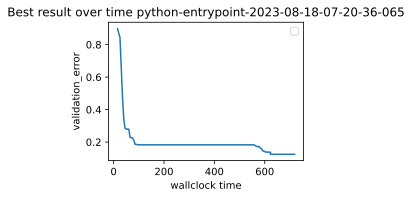

In [7]:
d2l.set_figsize()
e = load_experiment(tuner.name)
e.plot()

## Visualize the Optimization Process

Once more, we visualize the learning curves of every trial (each color in the plot represents a trial). Compare this to
asynchronous random search in :numref:`sec_rs_async`. As we have seen for
successive halving in :numref:`sec_mf_hpo`, most of the trials are stopped
at 1 or 2 epochs ($r_{\mathrm{min}}$ or $\eta * r_{\mathrm{min}}$). However, trials do not stop
at the same point, because they require different amount of time per epoch. If
we ran standard successive halving instead of ASHA, we would need to synchronize
our workers, before we can promote configurations to the next rung level.


Text(0, 0.5, 'objective function')

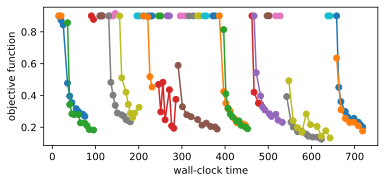

In [8]:
d2l.set_figsize([6, 2.5])
results = e.results
for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id]
    d2l.plt.plot(
        df["st_tuner_time"],
        df["validation_error"],
        marker="o"
    )
d2l.plt.xlabel("wall-clock time")
d2l.plt.ylabel("objective function")

## Summary

Compared to random search, successive halving is not quite as trivial to run in
an asynchronous distributed setting. To avoid synchronisation points, we promote
configurations as quickly as possible to the next rung level, even if this means
promoting some wrong ones. In practice, this usually does not hurt much, and the
gains of asynchronous versus synchronous scheduling are usually much higher
than the loss of the suboptimal decision making.


[Discussions](https://discuss.d2l.ai/t/12101)
